In [5]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import cftime
import PyFT as pyft

### Generate Mock Data

In [6]:
# # Generate data WITHOUT GAPS
# pyft.generate_data(dt=0.05, T_start=0, T_end=100, noise_level_1=0.2, noise_level_2=0.2*10, verbose=1)

# Generate data WITH GAPS
# pyft.generate_data_with_gaps(dt=0.05, T_start=0, T_end=200, w=2, a0=3, phase=0, yshift=10, noise=False, noise_level=0.2, gap_multiplier=4, lambdas=2.5, verbose=1)

### Main Code as Function

In [7]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import cftime
import PyFT as pyft

def power_spectrum(data_path, time_column, column_of_interest, df=None, f_int=None, time_units=["s", "ms"], weights_column=None, unc_column=None, verbose=2, recommendations=False, calc_unc=False, plotting=2):
    from scipy import signal
    import os
    import numpy as np
    import PyFT as pyft
    import matplotlib.pyplot as plt

    #------------------------------------------
    # READING, CLEANING, & STRUCTURING DATA
    #------------------------------------------

    # Convert time units
    conversion_factor = pyft.conversion_factor(time_units[0], time_units[1])

    # Process the data
    current_dir = os.getcwd()
    filename, extension = data_path.rsplit('.', 1)

    # Extract the base name (mockdata.csv)
    filename = os.path.basename(filename)
    
    ds = pyft.process_df(data_path, time_column, column_of_interest, weights_column=weights_column, unc_column=unc_column, calc_unc=calc_unc, verbose=0)

    signal_column = 'signal'

    # Calculate key values
    dt = pyft.calc_dt(ds['time'])  # Average timestep of data
    if verbose == 2:
        print(f"Average timestep: {dt}")
    T = (ds['time'][-1] - ds['time'][0]).item()  # Time length of data
    f_nyq = 1 / (2 * dt)  # Nyquist Frequency (in chosen units)
    df_rec = 1 / (5 * T)  # Recommended sampling frequency (oversampling using df = 1/5T)
    f_int_nyq = [0, f_nyq * 0.9]  # Recommended frequency interval (from 0 to 0.9 * Nyquist Frequency)

    # Print recommended sampling frequency if enabled
    if recommendations:
        print(f"Recommended sampling frequency: {df_rec:.4f} Hz.")

    # Check and set default values for frequency step and interval
    if df is None:
        if verbose > 0:
            print(f"No frequency step given. Using recommended df = {df_rec*conversion_factor:.4f}")
        df = df_rec

    if f_int is None:
        if verbose > 0:
            print(f"No frequency interval given. Testing from 0 to 0.9 * Nyquist Frequency, {np.array(f_int_nyq)*conversion_factor} Hz.")
        f_int = f_int_nyq

    # Create frequency array
    freq = np.arange(f_int[0]*conversion_factor, f_int[1]*conversion_factor, step=df*conversion_factor)
    ds.coords['freq'] = freq

    #------------------------------------------
    # FOURIER TRANSFORM CODE
    #------------------------------------------
    # Precompute sin(f*time) and cos(f*time)
    sin_vals = np.sin(2 * np.pi * np.outer(freq, ds['time']))
    cos_vals = np.cos(2 * np.pi * np.outer(freq, ds['time']))

    # Compute s, c, ss, cc, sc
    s_data = np.sum(ds['weights'].values * ds[signal_column].values * sin_vals, axis=1)
    c_data = np.sum(ds['weights'].values * ds[signal_column].values * cos_vals, axis=1)
    ss_data = np.sum(ds['weights'].values * sin_vals ** 2, axis=1)
    cc_data = np.sum(ds['weights'].values * cos_vals ** 2, axis=1)
    sc_data = np.sum(ds['weights'].values * cos_vals * sin_vals, axis=1)

    # Add computed values to the dataset
    ds['s'] = ('freq', s_data)
    ds['c'] = ('freq', c_data)
    ds['ss'] = ('freq', ss_data)
    ds['cc'] = ('freq', cc_data)
    ds['sc'] = ('freq', sc_data)

    # Compute alpha and beta
    alpha = (ds['s'] * ds['cc'] - ds['c'] * ds['sc']) / (ds['ss'] * ds['cc'] - ds['sc'] ** 2)
    beta = (ds['c'] * ds['ss'] - ds['s'] * ds['sc']) / (ds['ss'] * ds['cc'] - ds['sc'] ** 2)
    ds = ds.drop_vars(['s', 'c', 'ss', 'cc', 'sc'])

    # Add alpha and beta to the dataset
    ds['alpha'] = ('freq', alpha.data)
    ds['beta'] = ('freq', beta.data)

    # Compute power spectrum
    P = ds['alpha'] ** 2 + ds['beta'] ** 2
    ds['P'] = ('freq', P.data)

    ds['freq'] = ds['freq'] / conversion_factor
    ds['time'] = ds['time']

    #------------------------------------------
    # PLOTTING & FILE OUTPUT
    #------------------------------------------
    if plotting >= 1:
        os.makedirs(current_dir + '/plots', exist_ok=True)

        # Create a figure and two subplots
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

        # Plot the time series data on the first subplot
        ds[signal_column].plot(ax=axes[0])
        axes[0].set_title("Time Series Data")
        axes[0].set_xlabel(f"Time ({time_units[0]})")
        axes[0].set_ylabel("Units")

        # Plot the power spectral density on the second subplot
        ds['P'].plot(ax=axes[1])
        axes[1].set_title("Power Spectrum of Time Series")
        axes[1].set_xlabel(f"Freq ({time_units[1]}$^{{-1}}$)")
        axes[1].set_ylabel("Power Spectral Density")

        # Adjust layout to prevent overlap
        plt.tight_layout()

        # Display the plots
        plt.savefig(f"plots/{filename}_PS.png")
        plt.show()
        plt.close()

    os.makedirs(current_dir + '/PS_Data', exist_ok=True)
    ds.to_netcdf(f'PS_Data/{filename}_PS.nc')

    #------------------------------------------
    # FINDING RECOMMENDED F INTERVAL
    #------------------------------------------
    # Find the frequency interval containing significant peaks
    max_idx = np.nanargmax(ds['P'].values)
    max_freq = ds['freq'].values[max_idx]  # Frequency with maximum power
    max_P = ds['P'].values[max_idx]  # Maximum power
    peak_thresh = 1 / 8 * max_P  # Threshold for significant peaks

    # Identify frequencies with power above the threshold
    above_threshold_indices = np.where(ds['P'].values > peak_thresh)[0]
    max_fthresh = ds['freq'].values[above_threshold_indices].max()
    min_fthresh = ds['freq'].values[above_threshold_indices].min()
    range_fthresh = max_fthresh - min_fthresh

    # Define the recommended frequency interval
    f_int_rec = [min_fthresh - range_fthresh/5, max_fthresh + range_fthresh/5]
    if recommendations:
        print(f"Recommended frequency interval: {f_int_rec} /{time_units[1]}.")

    # Plot the zoomed-in power spectrum if plotting mode is 2
    if plotting == 2:
        plt.figure(figsize=(10, 6))

        # Select the power spectral density within the recommended frequency range
        P_slice = ds['P'].sel(freq=slice(f_int_rec[0], f_int_rec[1]))

        # Plot the power spectral density for the selected frequency range
        P_slice.plot()
        plt.title("Power Spectrum of Time Series")
        plt.xlabel(f"Freq ({time_units[1]}$^{{-1}}$)")
        plt.ylabel("Power Spectral Density")
        plt.savefig(f"{current_dir}/plots/{filename}_PS_ZOOMED.png")
        plt.show()
        plt.close()

## Run Program Interface

HTML(value='\n    <div style="background-color: #dff0d8; padding: 10px; border-radius: 5px; border: 1px solid …

Average timestep: 0.01
Recommended sampling frequency: 0.0020 Hz.


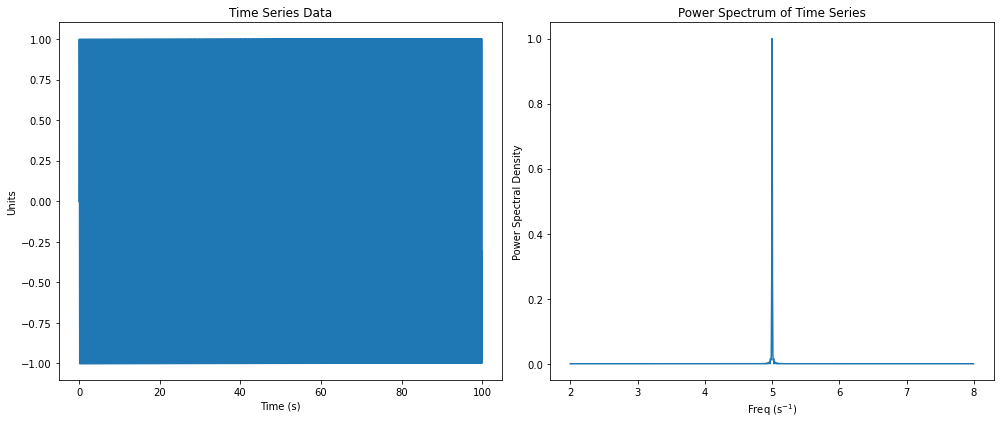

Recommended frequency interval: [4.991599999999892, 5.008399999999892] /s.


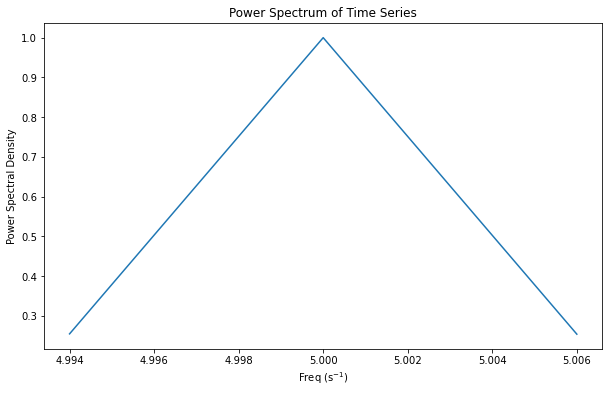

In [8]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import tkinter as tk
from tkinter import filedialog as fd
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import cftime
import PyFT as pyft

# Initialise lists for different types of messages
warnings = []
infos = []
dangers = []
successes = []

############
# FUNCTIONS
############

def select_file(button):
    """Prompt the user to select a file using a file dialog and update the input widget."""
    root = tk.Tk()  # Create a root window
    root.withdraw()  # Hide the root window
    datapath_input.value = fd.askopenfilename()  # Prompt the user to select a file
    root.destroy()  # Destroy the root window after the file dialog is closed

def check_datapathinfo(change):
    """Check the selected file path and update warnings based on file extension."""
    global warnings
    datapath = datapath_input.value

    unsupported_format_warning = "<b>Oops!</b> Unsupported file format. Please use '.csv' or '.nc' formats."

    if datapath == "":
        # Remove warning if no file is selected
        if unsupported_format_warning in warnings:
            warnings.remove(unsupported_format_warning)
    else:
        # Check file extension
        if '.' in datapath:
            filename, extension = datapath.rsplit('.', 1)
            if extension not in ['csv', 'nc']:
                # Add warning for unsupported file format
                if unsupported_format_warning not in warnings:
                    warnings.append(unsupported_format_warning)
            else:
                # Remove warning if file format is supported
                if unsupported_format_warning in warnings:
                    warnings.remove(unsupported_format_warning)
    
    # Update the warning message display
    update_html_content_warning(change)

def toggle_check_box(check_box):
    """Toggle the value of a checkbox widget."""
    check_box.value = not check_box.value

def run_update_info():
    """Update the info message display."""
    toggle_check_box(check_infobox)

def run_update_warning():
    """Update the warning message display."""
    toggle_check_box(check_warningbox)

def run_update_danger():
    """Update the danger message display."""
    toggle_check_box(check_dangerbox)
    
def run_update_success():
    """Update the success message display."""
    toggle_check_box(check_successbox)

def freqrecs(button):
    """Give recommended frequencies to input - esepecially useful for large datasets"""
    data_path = datapath_input.value
    time_column = timecol_input.value
    column_of_interest = datacol_input.value
    time_units = [timeunit_input.value, frequnit_input.value[:-2]]
    
    ds = pyft.process_df(data_path, time_column, column_of_interest)
    msg = pyft.process_df_and_calc_values(ds, time_units=time_units, verbose=0, button=True)
    update_info_message(msg)
    
def find_columns(button):
    """Find and display columns or data variables and coordinates from the selected file."""
    global infos
    datapath = datapath_input.value

    # Messages to be removed from warnings
    messages_to_remove = [
        "<b>Unsupported file format.</b> Please use '.csv' or '.nc' formats.",
        "<b>Oops!</b> Must select a '.csv' or '.nc' file first.",
        "<b>Oops!</b> File not found."
    ]

    # Remove specified messages from warnings
    for message in messages_to_remove:
        if message in warnings:
            warnings.remove(message)

    try:
        filename, extension = datapath.rsplit('.', 1)
        if extension == 'csv':
            process_csv_file(datapath)
        elif extension == 'nc':
            process_nc_file(datapath)
        else:
            add_warning_message("<b>Unsupported file format.</b> Please use '.csv' or '.nc' formats.")
    except ValueError:
        add_warning_message("<b>Oops!</b> Must select a '.csv' or '.nc' file first.")
    except FileNotFoundError:
        add_warning_message("<b>Oops!</b> File not found.")

def process_csv_file(datapath):
    """Process and extract columns from a CSV file."""
    df = pd.read_csv(datapath)
    columns = df.columns.tolist()
    update_info_message(f"<b>Select any of:</b> {columns}")

def process_nc_file(datapath):
    """Process and extract data variables and coordinates from a NetCDF file."""
    ds = xr.open_dataset(datapath)
    data_vars = list(ds.data_vars)
    coords = list(ds.coords)
    update_info_message(f"<b>Select any of:</b> <br> Data variables {data_vars} <br> Coordinates {coords}")

def update_info_message(message):
    """Update the info message display with the provided message."""
    global infos
    infos = []
    if message not in infos:
        infos.append(message)
    info_type.value = "info"
    toggle_check_box(check_infobox)

def add_warning_message(message):
    """Add a warning message to the warnings list."""
    if message not in warnings:
        warnings.append(message)
    warning_type.value = "warning"
    run_update_warning()

def toggle_check_box(check_box):
    """Toggle the value of a checkbox widget."""
    check_box.value = not check_box.value

def show_additional_field(button):
    """Toggle the display of additional input fields."""
    if additional_fields.layout.display == 'none':
        additional_fields.layout.display = 'block'
    else:
        additional_fields.layout.display = 'none'

def check_uncertainty(change):
    """Check and manage warnings related to the uncertainty calculation option."""
    global warnings
    warning_msg = ("<b>Oops!</b> If the \"Calculate Uncertainty\" option is selected, the Uncertainty column should not be used. "
                   "Please choose only one feature.")
    if (unccol_input.value != "") and calcunc_input.value:
        if warning_msg not in warnings:
            warnings.append(warning_msg)
    else:
        if warning_msg in warnings:
            warnings.remove(warning_msg)
    update_html_content_warning(change)

def check_stepinfo(change):
    """Check if the frequency step is a number type and update warnings."""
    global warnings
    if df_input.value == "":
        remove_warning("<b>Oops!</b> Frequency step must be a number type.")
    else:
        try:
            float(df_input.value)
            remove_warning("<b>Oops!</b> Frequency step must be a number type.")
        except ValueError:
            add_warning("<b>Oops!</b> Frequency step must be a number type.")
    update_html_content_warning(change)

def check_freqinfo(change):
    """Check if start frequency is less than end frequency and if intervals are a number type."""
    global warnings
    try:
        start_value = float(fint_start_input.value)
        end_value = float(fint_end_input.value)
        if start_value < end_value:
            remove_warning("<b>Oops!</b> Start frequency must be less than end frequency.")
        else:
            add_warning("<b>Oops!</b> Start frequency must be less than end frequency.")
        remove_warning("<b>Oops!</b> Frequency intervals must be a number type.")
    except ValueError:
        add_warning("<b>Oops!</b> Frequency intervals must be a number type.")
    update_html_content_warning(change)

def update_html_content_warning(change):
    """Update the HTML content based on the warnings."""
    global warnings
    
    if warnings:
        warning_type.value = 'warning'
        message_warning.value = "<b>⚠️ Warning!</b><br>" + "<br>".join(warnings) if len(warnings) == 1 else "<b>⚠️ Warnings!</b><br>" + "<br>".join(warnings)
    else:
        warning_type.value = 'hidden'
        message_warning.value = ""
    
    bg_color_warning = "#fcf8e3" if warning_type.value == 'warning' else "#ffffff"
    bord_color_warning = "#faeacc" if warning_type.value == 'warning' else "#ffffff"
    warningbox.layout.display = 'block' if warning_type.value == 'warning' else 'none'

    html_content_warning = f"""
    <div style="background-color: {bg_color_warning}; padding: 10px; border-radius: 5px; border: 1px solid {bord_color_warning};">
        {message_warning.value}
    </div>
    """
    warningbox.value = html_content_warning

def add_warning(warning):
    """Add a warning message to the warnings list if it's not already present."""
    global warnings
    if warning not in warnings:
        warnings.append(warning)

def remove_warning(warning):
    """Remove a warning message from the warnings list if it's present."""
    global warnings
    if warning in warnings:
        warnings.remove(warning)
    
def update_html_content_info(change):
    """Update the HTML content based on the information."""
    global infos
    bg_color_info = "#ffffff"  # Default background color
    bord_color_info = "#ffffff"  # Default border color
    
    if infos:
        message_info.value = "<b>💡 Information:</b><br>" + "<br>".join(infos)
    else:
        message_info.value = ""
    
    if info_type.value == 'info':
        bg_color_info = "#d9edf7"
        bord_color_info = "#bce8f1"
        infobox.layout.display = 'block'
    elif info_type.value == 'hidden':
        bg_color_info = "#ffffff"
        bord_color_info = "#ffffff"
        infobox.layout.display = 'none'
    
    html_content_info = f"""
    <div style="background-color: {bg_color_info}; padding: 10px; border-radius: 5px; border: 1px solid {bord_color_info};">
        {message_info.value}
    </div>
    """
    infobox.value = html_content_info

def update_html_content_danger(change):
    """Update the HTML content based on the dangers."""
    global dangers
    bg_color_danger = "#ffffff"  # Default background color
    bord_color_danger = "#ffffff"  # Default border color
    if dangers:
        message_danger.value = "<b>💀 Program Failed:</b><br>" + "<br>".join(dangers)
    else:
        message_danger.value = ""
    
    if danger_type.value == 'danger':
        bg_color_danger = "#f2dede"
        bord_color_danger = "#ebccd1"
        dangerbox.layout.display = 'block'
    elif danger_type.value == 'hidden':
        bg_color_danger = "#ffffff"
        bord_color_danger = "#ffffff"
        dangerbox.layout.display = 'none'
    
    html_content_danger = f"""
    <div style="background-color: {bg_color_danger}; padding: 10px; border-radius: 5px; border: 1px solid {bord_color_danger};">
        {message_danger.value}
    </div>
    """
    dangerbox.value = html_content_danger

def update_html_content_success(change):
    """Update the HTML content based on the successes."""
    global successes
    bg_color_success = "#ffffff"  # Default background color
    bord_color_success = "#ffffff"  # Default border color
    if successes:
        message_success.value = "".join(successes)
        successbox.layout.display = 'block'
    else:
        message_success.value = ""
        successbox.layout.display = 'none'
    
    if success_type.value == 'success':
        bg_color_success = "#dff0d8"
        bord_color_success = "#d7e8c6"
        successbox.layout.display = 'block'
    elif success_type.value == 'hidden':
        bg_color_success = "#ffffff"
        bord_color_success = "#ffffff"
        message_success.value = ""
        successbox.layout.display = 'none'
        
        
    html_content_success = f"""
    <div style="background-color: {bg_color_success}; padding: 10px; border-radius: 5px; border: 1px solid {bord_color_success};">
        {message_success.value}
    </div>
    """
    successbox.value = html_content_success

##################
# RANDOM SHORTCUTS
##################
vspacer = widgets.Box(layout=widgets.Layout(height='20px'))
hspacer = widgets.Box(layout=widgets.Layout(width='20px'))
style = {'description_width': 'initial'}
rd = "<span style=\"color: red\">*</span>"

##################
# MESSAGE BOX
##################

# Message widgets
message_warning = widgets.Text()
message_info = widgets.Text()
message_danger = widgets.Text()
message_success = widgets.Text()

# Message types
warning_type = widgets.Text(value='hidden')
info_type = widgets.Text(value='hidden')
danger_type = widgets.Text(value='hidden')
success_type = widgets.Text(value='hidden')

# HTML content
html_content_warning = ""
html_content_info = ""
html_content_danger = ""
html_content_success = ""

# HTML containers
warningbox = widgets.HTML(value=html_content_warning)
infobox = widgets.HTML(value=html_content_info)
dangerbox = widgets.HTML(value=html_content_danger)
successbox = widgets.HTML(value=html_content_success)

# Checkboxes
check_infobox = widgets.Checkbox()
check_warningbox = widgets.Checkbox()
check_dangerbox = widgets.Checkbox()
check_successbox = widgets.Checkbox()

infobox.layout.display = 'none'
warningbox.layout.display = 'none'
successbox.layout.display = 'none'
dangerbox.layout.display = 'none'


##################
# MANDATORY FIELDS
##################
header_rec = widgets.HTML(value='<b>Data Info</b>')

# Create the recommended fields
datapath_input = widgets.Text(
    description=f'Data Path{rd}',
    layout=widgets.Layout(width='500px'),
    placeholder='Enter datapath'
)
datapath_button = widgets.Button(description='Select File')
datapath_button.on_click(select_file)

timecol_input = widgets.Text(
    description=f'Time Column{rd}',
    layout=widgets.Layout(width='250px'),
    placeholder='Enter time column',
    style=style
)
datacol_input = widgets.Text(
    description=f'Data Column{rd}:',
    layout=widgets.Layout(width='250px'),
    placeholder='Enter data column',
    style=style
)
unccol_input = widgets.Text(
    description='Uncert Column:',
    layout=widgets.Layout(width='250px'),
    placeholder='',
    style=style,
    value=''
)
weights_input = widgets.Text(
    description='Weights Column:',
    layout=widgets.Layout(width='250px'),
    placeholder='',
    style=style,
    value=''
)
colfind_button = widgets.Button(description='Find options')
colfind_button.on_click(find_columns)

timeunit_options = [
    "ns", "ms", "s", "min", "hr", "day", "mon", "yr", "common mon", "common yr"
]
timeunit_input = widgets.Dropdown(
    description='Time Units:',
    options=timeunit_options,
    value='s',
    layout=widgets.Layout(width='200px')
)
frequnit_options = [
    "ns⁻¹", "ms⁻¹", "s⁻¹", "min⁻¹", "hr⁻¹", "day⁻¹", "mon⁻¹", "yr⁻¹", "common mon⁻¹", "common yr⁻¹"
]
frequnit_input = widgets.Dropdown(
    description='Desired Freq Units',
    options=frequnit_options,
    value='ms⁻¹',
    style=style,
    layout=widgets.Layout(width='250px')
)

# Create input field boxes
file_selection_box = widgets.HBox([datapath_input, datapath_button])
column_selection_box = widgets.HBox([timecol_input, datacol_input, colfind_button])
uncweights_selection_box = widgets.HBox([unccol_input, weights_input])
units_box = widgets.HBox([timeunit_input, hspacer, frequnit_input])

# Arrange input field boxes vertically
mandatory_fields = widgets.VBox([header_rec, file_selection_box, column_selection_box, uncweights_selection_box, units_box])

###############
# RECOMMENDED FIELDS
###############
header_rec = widgets.HTML(value='<b>Frequency Info (Recommended)</b>')
desc_rec = widgets.HTML(
    value="1. Keep these values in the units you desire for the power spectrum data. <br> 2. Large datasets can overwhelm computer memory with the default interval, potentially causing crashes. Specify an interval to mitigate this risk."
)
textbox_rec = widgets.VBox([header_rec, desc_rec])

freqrecs_button = widgets.Button(description='Give recommendations')
freqrecs_button.on_click(freqrecs)

df_input = widgets.Text(description='Freq Step:', layout=widgets.Layout(width='150px'))
fint_start_input = widgets.Text(description='Start Freq:', layout=widgets.Layout(width='150px'))
fint_end_input = widgets.Text(description='End Freq:', layout=widgets.Layout(width='150px'))

fint_input_box = widgets.HBox([fint_start_input, fint_end_input, freqrecs_button])

# Arrange input field boxes vertically
recommended_fields = widgets.VBox([textbox_rec, df_input, fint_input_box])

###############
# ADDITIONAL FIELDS
###############
button_layout = widgets.Layout(
    width='80%',
    align_items='center'  # Center the content vertically
)
trigger_button = widgets.Button(description='See Additional Program Options', layout=button_layout)
calcunc_input = widgets.Checkbox(description=f'Calculate Uncertainty', value=False)
recommendations_input = widgets.Checkbox(description=f'Give Recommendations')
plotting_options = [
    "0: No plots will be generated",
    "1: Power spectrum will be plotted",
    "2: Zoomed-in power spectrum will also be plotted using the recommended interval"
]
plotting_input = widgets.Dropdown(
    description='Plotting Options:',
    options=plotting_options,
    style=style,
    layout=widgets.Layout(width='620px',
    value="2: Zoomed-in power spectrum will also be plotted using the recommended interval")
)
verbose_options = [
    "0: Minimal output",
    "2: Detailed output"
]
verbose_input = widgets.Dropdown(
    description='Verbosity:',
    options=verbose_options,
    style=style,
    layout=widgets.Layout(width='250px')
)

checkbox_box = widgets.HBox([calcunc_input, recommendations_input])

additional_fields = widgets.VBox([checkbox_box, plotting_input, verbose_input])
additional_fields.layout.display = 'none'  # Hide the fields initially

# Link the button to the function
trigger_button.on_click(show_additional_field)


###############
# LEGEND
###############
mand_field = widgets.HTML(value=f"{rd} Mandatory Field")

###############
# SUBMIT BUTTON
###############
# Create a submit button
submit_button = widgets.Button(description='Run Program', button_style='success')

# Function to handle form submission
def submit_form(button):
    clear_output(wait=True)
    display(widgets.VBox([
        mandatory_fields, vspacer, recommended_fields, vspacer, trigger_button, additional_fields,
        mand_field, submit_button, vspacer, infobox, warningbox
    ]))
    global data_path, time_column, column_of_interest, unc_column, df, f_int, time_units, verbose, plotting, recommendations, calc_unc, dangers, successes

    # Retrieve form data
    data_path = datapath_input.value
    time_column = timecol_input.value
    column_of_interest = datacol_input.value
    unc_column = unccol_input.value if unccol_input.value != "" else None
    weights_column = weights_input.value if weights_input.value != "" else None
    df = float(df_input.value) if df_input.value != "" else None
    f_int = [float(fint_start_input.value), float(fint_end_input.value)] if fint_start_input.value != "" or fint_end_input.value != "" else None
    time_units = [timeunit_input.value, frequnit_input.value[:-2]]
    verbose = 2 if verbose_input.value == "2: Detailed output" else 0
    plotting = 0 if plotting_input.value == "0: No plots will be generated" else 1 if plotting_input.value == "1: Power spectrum will be plotted" else 2
    recommendations = recommendations_input.value
    calc_unc = calcunc_input.value
    
    try:
        dangers = []
        successes = []
        successes.append("<b>Running Program...</b>")
        success_type.value = "success"
        run_update_success()
        display(successbox)
        power_spectrum(data_path, time_column, column_of_interest, df=df, f_int=f_int, 
           time_units=time_units, weights_column=weights_column, unc_column=unc_column, 
           verbose=verbose, recommendations=recommendations, calc_unc=calc_unc, plotting=plotting)
        successes.remove("<b>Running Program...</b>")
        successes.append("<b>✅ Program complete!")
        run_update_success()
    except FileNotFoundError as fe:
        if "<b>Yikes!</b> File not found." not in dangers:
            dangers.append("<b>Yikes!</b> File not found.")
            success_type.value = "hidden"
            run_update_success()
            danger_type.value = "danger"
            run_update_danger()
            display(dangerbox)
    except KeyError as ke:
        key_error_message = f"<b>Yikes!</b> Failed to recognise a <code>{ke.args[0]}</code> column. Please double-check your columns and try again."
        if key_error_message not in dangers:
            success_type.value = "hidden"
            run_update_success()
            dangers.append(key_error_message)
            danger_type.value = "danger"
            run_update_danger()
            display(dangerbox)
        

# Link the submit button to the function
submit_button.on_click(submit_form)

###############
# WARNINGS & INFO
###############
# Attach observers
datapath_input.observe(check_datapathinfo, 'value')
fint_start_input.observe(check_freqinfo, 'value')
fint_end_input.observe(check_freqinfo, 'value')
df_input.observe(check_stepinfo, 'value')
unccol_input.observe(check_uncertainty, 'value')
calcunc_input.observe(check_uncertainty, 'value')
message_warning.observe(update_html_content_warning, 'value')
message_info.observe(update_html_content_warning, 'value')
check_infobox.observe(update_html_content_info, names='value')
check_warningbox.observe(update_html_content_warning, names='value')
check_dangerbox.observe(update_html_content_danger, names='value')
check_successbox.observe(update_html_content_success, names='value')

# Display the trigger button, input fields, and submit button
display(widgets.VBox([
    mandatory_fields, vspacer, recommended_fields, vspacer, trigger_button, additional_fields,
    mand_field, submit_button, vspacer, infobox, warningbox, dangerbox, successbox
]))
    
#program_interface()

